# Process and Analyse SSPALS

Create simulated SSPALS spectra for hi- and low-gain oscilloscope channels, 
combine together and analyse to find the delayed fraction.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sspals

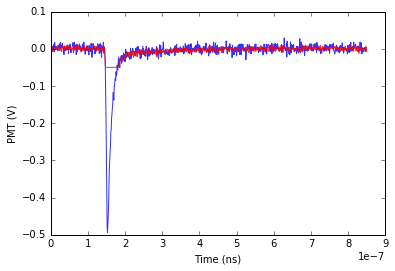

In [2]:
# simulate data
dt = 1e-9
t  = np.arange(-1.5E-7, 7.0E-7, dt)
sim = -sspals.sim(t, eff=0.28)

h_noise = 0.004         # scale of noise to add to hi-gain channel
h_min = -0.05           # range of the hi-gain channel
h_max = 0.03
l_noise = 0.008         # scale of noise to add to low-gain channel
offset = 0.002          # add a random offset to both channels
repeats = 100

# data
hi = []
low = []
for i in range(repeats):
    hi.append(np.clip(np.add(sim, 
            np.random.normal(np.random.rand()*offset, h_noise, len(sim))), h_min, h_max))
    low.append(np.add(sim, 
            np.random.normal(np.random.rand()*offset, l_noise, len(sim))))
hi = np.array(hi)
low = np.array(low)
xdata = np.arange(len(hi[0])) * dt

# plot
fig, ax = plt.subplots()
ax.plot(xdata, low[0], alpha=0.8)
ax.plot(xdata, hi[0], alpha=0.8, c='r')

ax.set_xlabel('Time (ns)')
ax.set_ylabel('PMT (V)')

plt.show()

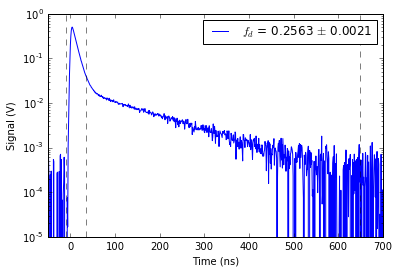

In [3]:
# combine data
chmx = sspals.chmx(hi, low)

# analyse
limits=[-1.0E-8, 3.5E-8, 6.5E-7]
DF = sspals.sspals(chmx, dt, limits=limits, threshold=0.04)

# trigger
t0 = np.nanmean(DF.t0)

# plot average
fig, ax = plt.subplots()
reps = np.logical_not(np.isnan(DF.DF)).sum()
ax.plot((xdata -t0)*1e9, np.mean(chmx, 0), label='$f_d$ = %.4f $\pm$ %.4f'%(np.nanmean(DF.DF),
                                                                       np.nanstd(DF.DF)/ np.sqrt(reps)
                                                                      ))
for lim in limits:
    ax.axvline(lim*1e9, c='k', ls='--', alpha=0.5)
ax.set_yscale('log')
ax.set_xlim(-50, 700)
ax.set_ylim(1e-5, 1)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Signal (V)')
ax.legend()

plt.show()

In [4]:
# analysis
DF.head()

,t0,AC,BC,DF
0,1.489293e-07,9.995519e-09,2.573993e-09,0.257515
1,1.488500e-07,1.023461e-08,2.858124e-09,0.279261
2,1.488545e-07,1.054424e-08,3.141322e-09,0.297918
3,1.489067e-07,1.001606e-08,2.653844e-09,0.264959
4,1.489332e-07,9.921698e-09,2.689891e-09,0.271112


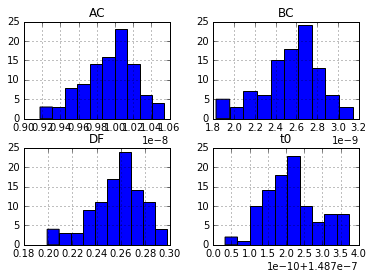

In [5]:
DF.hist()
plt.show()